# Matching trades to order book updates

## Introduction

Exchanges receive three types of orders:
- **Limit orders**, making liquidity
- **Market orders**, taking liquidity
- **Cancel orders**, taking liquidity

Limit orders are standing offers to buy (sell) a defined amount at a defined price. They can be cancelled using Cancel orders. Market orders are orders to buy a defined amount at market price: the best price which can be achieved using standing offers. Limit orders are accumulated and aggregated into a tick level order book, which contains the size of aggregated standing offers at each price. Market orders trigger one or more trades when they are matched with one or more Limit orders.

---

![Order book GIF](https://upload.wikimedia.org/wikipedia/commons/1/14/Order_book_depth_chart.gif)

---

Exchanges stream the order book updates and the trades flow to market participants, but never stream the order flow. The order flow is valuable data which can be used to study agents' behavior on the market, and possibly design algorithmic trading strategies. We attempt to reconstruct the order flow from the order book updates and trades flow.

---

## Modeling the order book

We begin by studying the order flow for a given price and direction (buy / sell), on a given time interval $I$. Fixing these variables, we may study the changes in liquidity as a measure over time:

$$
\begin{align}
      & L(t) : \text{ the liquidity at time $t \in I$}  \\
      & \ell : \text{ the borel measure associated to $L$}  \\
      & \ell( (t_0, t_1] ) = L(t_1) - L(t_0)
\end{align}
$$

We also observe the trades at this price, and in this direction (taker buys, maker sells, or inversely). We model it the same way:

$$
\begin{align}
      & A(t) : \text{ the accumulated traded amount at time $t \in I$}  \\
      & a : \text{ the borel measure associated to $L$}  \\
      & a( (t_0, t_1] ) = A(t_1) - A(t_0)
\end{align}
$$

We are dealing with discrete information, and letting $\ell_t$ ($a_t$) represent the liquidity (acummulated traded amount), we may represent our measures as

$$
\begin{align}
    \ell &= \sum_i l_{t_i} \delta_{t_i}  \\
       a &= \sum_i a_{t_i} \delta_{t_i}
\end{align}
$$

These measures represent the information streamed by the exchange. They are therefore imperfect representations of the true changes in liquidity and trade flow. Inaccuracies may come from:
- Aggregation of order book updates
- Aggregation of trades
- Timestamp inaccuracies: trade timestamps may be unequal to that of the order book update they caused

Additionally, trades do not map one to one with market orders, due to
- Possible trade aggregation when several market orders are passed at the same time
- Market order decomposition to match with several different limit orders at the same price
- As above, but at different prices (cannot be studied when only considering one price as we currently do)

We may now express the problem: we wish to decompose the changes in liquidity into the limit ($r$), market ($m$) and cancel ($c$) order flows, all of which are represented as unsigned (positive) measures.

$$
\ell = r - m - c
$$

In this model $m$ isn't really the market order flow, but rather the consequence of the market order flow on the liquidity at the given price level.

---

## A simplifying assumption

There exists a decomposition of $\ell$ such that $\ell^+ = r$ and $\ell^- = m + c$. There is no guarantee, however, that this is the jordan decomposition of $\ell$ (such that $\text{supp } \ell^- \cap \text{supp } \ell^+ = \varnothing$). In fact, it will often be the case that trades appear in positive order book updates when exchanges aggregate data.

In this section we make the simplifying assumption that the jordan decomposition coincides with the proposed decomposition. This is only valid in the case where exchanged do not aggregate order book updates and trades. Under this hypothesis, our problem reduces to decomposing

$$
\ell^- = m + c
$$

that is, decomposing negative liquidity updates into market orders and cancel orders.

---

We assume $a(I) = m(I)$. This comes from the local nature of inaccuracies. The constraints on $m$ are then:

$$
\begin{align}
    & m(I) = a(I)  \\
    & 0    \leq m \leq \ell^-
\end{align}
$$

We would like to find an $m$ so that market orders are found temporally very close to trades modeled by $a$. Precisely, we wish to find some $m$ with minimal earth mover distance from $a$. Letting $n = \text{supp } a$, $k = \text{supp } m$, this gives the following optimization problem:

$$
\begin{align}
    \min_{T \geq 0, m \geq 0} & \sum_{i \leq n, j \leq k} T_{ij} C_{ij}  \\
                         s.t. & \sum_{j \leq k} T_{ij} = a_{t_i}  \\
                              & \sum_{i \leq n} T_{ij} = m_{t_j}
\end{align}
$$

We can substitute $m_{t_j} = \ell^-_{t_j} - c_j$ and find

$$
\begin{align}
    \min_{T \geq 0, c \geq 0} & \sum_{i \leq n, j \leq k} T_{ij} C_{ij}  \\
                         s.t. & \sum_{j \leq k} T_{ij} = a_{t_i}  \\
                              & \sum_{i \leq n} T_{ij} + c_j = \ell^-_{t_j}
\end{align}
$$

Finally defining $a_{t_{n + 1}} = \sum_{j \leq k} c_j$, $T_{n + 1, j} = c_j$, and $C_{n + 1, j} = 0$ (pardon the abuse of notation), we find a Kantorovich OT problem:

$$
\begin{align}
    \min_{T \geq 0} & \sum_{i \leq n + 1, j \leq k} T_{ij} C_{ij}  \\
                         s.t. & \sum_{j \leq k} T_{ij} = a_{t_i}  \\
                              & \sum_{i \leq n + 1} T_{ij} = \ell^-_{t_j}
\end{align}
$$

This problem is a transport problem which matches trades to negative liquidity changes, with a cost which we can define to be the absolute value of the difference in timestamp at which th information was received. Negative liquidity changes which cannot be explained by trades are explained by cancellations: we have effectively created a virtual trade accounting for all cancel orders.

Finding the transport plan $T$ amounts to finding both $m$ and $c$ and solving our problem in the simplified case.

---

By letting the underlying measure space be two-dimensional, so that it represents both time and price, we can compute the matching for several prices at the same time by setting an infinite cost for matching trades and liquidity changes at different prices. The solution to the OT problem will yield an $m$ in two dimensions, which can be analyzed to recover a likely market order flow. When the data is not aggregated, the problem of reconstructing the market order flow from the trades is timestamp clustering.

### Experiments

We collect 10 minutes of data from the [Deribit crypto derivatives exchange](https://www.deribit.com).

In [1]:
import websockets

from itertools import count
import datetime as dt
import asyncio as aio
import json


_id = count().__next__

async def trades():
    msg = \
    {
        "jsonrpc": "2.0",
        "method": "public/subscribe",
        "id": _id(),
        "params": {
            "channels": ["trades.BTC-PERPETUAL.raw"]
        }
    }
    
    async with websockets.connect('wss://www.deribit.com/ws/api/v2') as ws:
        await ws.send(json.dumps(msg))
        while ws.open:
            r = json.loads(await ws.recv())
            if 'method' in r:
                yield r

async def book():
    msg = \
    {
        "jsonrpc" : "2.0",
        "id" : _id(),
        "method" : "public/subscribe",
        "params" : {
            "channels" : ["book.BTC-PERPETUAL.raw"]
        }
    }

    async with websockets.connect('wss://www.deribit.com/ws/api/v2') as ws:
        await ws.send(json.dumps(msg))
        while ws.open:
            r = json.loads(await ws.recv())
            if 'method' in r:
                yield r

async def harvest(stream, duration):
    dat = []
    start = dt.datetime.now()

    async for e in stream:
        dat.append(e)
        if (dt.datetime.now() - start).total_seconds() > duration:
            return dat

interval = 600
t, b = await aio.gather(harvest(trades(), interval), harvest(book(), interval))

print(f'Number of trades streamed: {len(t)}\nNumber of book updates streamed: {len(b)}')

Number of trades streamed: 728
Number of book updates streamed: 123971


---

We transform the raw JSON data into `pandas` dataframes that we can work with.

In [2]:
import pandas as pd
from operator import itemgetter


columns = ('timestamp', 'direction', 'price', 'amount')

tds, _t = [], itemgetter(*columns)
for r in t:
    for tr in r['params']['data']:
        tds.append(_t(tr))
trades = pd.DataFrame(tds, columns=columns)

obu = []
for r in b:
    for _, price, amount in r['params']['data']['bids']:
        obu.append((r['params']['data']['timestamp'], 'buy', price, amount))
    for _, price, amount in r['params']['data']['asks']:
        obu.append((r['params']['data']['timestamp'], 'sell', price, amount))
updates = pd.DataFrame(obu, columns=columns)

trades.timestamp = pd.to_datetime(trades.timestamp, unit='ms')
updates.timestamp = pd.to_datetime(updates.timestamp, unit='ms')
trades.sort_values(by='timestamp', inplace=True)
updates.sort_values(by='timestamp', inplace=True)

# we consider updates, deribit feeds us absolute values
updates['change'] = updates.groupby(['direction', 'price']).amount.diff()
updates.change[pd.isnull(updates.change)] = 0
trades['change'] = trades.amount

<ipython-input-2-44b058a94b8d>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  updates.change[pd.isnull(updates.change)] = 0


---

The `trades` and `updates` dataframes have the same structure. We show `updates` below for reference. A `buy` trade results from a market order fulfilling a limit sell order. Therefore `buy` trades must be matched with `sell` negative updates.

In [3]:
updates

,timestamp,direction,price,amount,change
0,2021-05-10 14:24:07.263,buy,57438.0,29790.0,0.0
2054,2021-05-10 14:24:07.263,sell,57654.5,20000.0,0.0
2055,2021-05-10 14:24:07.263,sell,57657.0,110.0,0.0
2056,2021-05-10 14:24:07.263,sell,57658.0,280.0,0.0
2057,2021-05-10 14:24:07.263,sell,57658.5,150.0,0.0
...,...,...,...,...,...
188553,2021-05-10 14:34:07.044,sell,57472.5,0.0,-40000.0
188552,2021-05-10 14:34:07.044,sell,57473.0,56100.0,40000.0
188554,2021-05-10 14:34:07.062,buy,57381.0,0.0,-5730.0
188555,2021-05-10 14:34:07.072,buy,980.0,0.0,-10.0


In [4]:
# only work on one side of the order book
direction = 'buy'
trades = trades[trades.direction == direction]
updates = updates[updates.direction == ('buy' if direction == 'sell' else 'sell')]

# all positive updates are limit orders
updates = updates[updates.change < 0]
updates.change = - updates.change

---

To solve our problem we now only need to create the $a$ and $l$ vectors, and the $C$ cost matrix. We can then invoke an optimal transport package and reconstruct $T$.

In [5]:
import numpy as np

# n and m are negative updates and trades (including virtual)
n = updates.change.to_numpy()
m = trades.change.to_numpy()
m = np.append(m, (n.sum() - m.sum(),))  #  add enough cancel potential to explain all updates
assert n.sum() == m.sum()

# loss matrix C is abs(time difference) + inf * abs(price difference)
tdiff = (trades.timestamp.values[:, np.newaxis] - updates.timestamp.values[np.newaxis, :])
pdiff = (trades.price.values[:, np.newaxis] - updates.price.values[np.newaxis, :])
C = np.abs(tdiff.astype(float)) + np.where(np.abs(pdiff.astype(float)) == 0, 0, 100000000000)

# add virtual trade cost (0)
C = np.vstack((C, [np.zeros_like(n)]))

m.shape, n.shape, C.shape

((852,), (47051,), (852, 47051))

In [6]:
import ot

T = ot.emd(m, n, C)  # transport plan
T.shape

(852, 47051)

---

From our transport plan we can count how many trades are matched with order book updates with different timestamps. Below is a histogram of timestamp differences for matches. The majority of trades appear in negative order book updates with the same timestamp, but a significant amount appear a few milliseconds later.

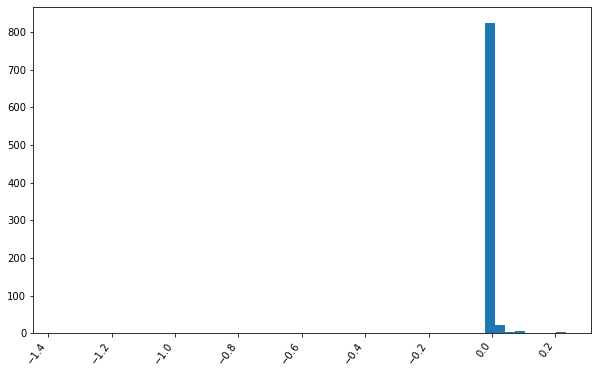

In [7]:
import matplotlib.pylab as pl

matches = []
for i, j in zip(*T.nonzero()):
    if i + 1 == T.shape[0]:  # skip cancel
        continue
    matches.append((trades.timestamp.iat[i], updates.timestamp.iat[j]))

matches = np.asarray(matches)
diffs   = (matches[:, 1] - matches[:, 0]).astype('timedelta64[ms]').astype(float) / 1000

pl.figure(figsize=(10, 6))
pl.hist(diffs, bins=50)
# pl.hist(diffs, bins=np.arange(diffs.max()))
pl.xticks(rotation=54, ha='right')

None

---

Our transport plan also allows us to count the number of trades with which each order book negative update is matched. In the following histogram we disregard matches with the virtual (cancel) trade. The majority of updates are explained by only 1 trade but a significant amount aggregate several trades.

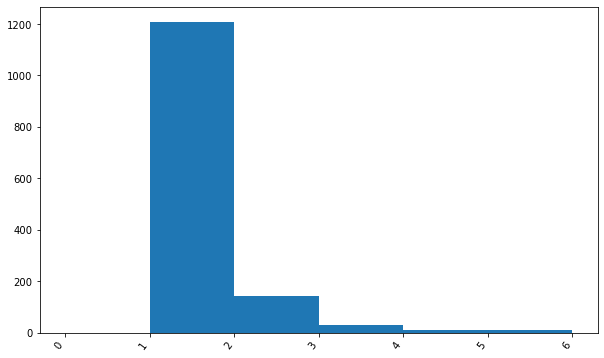

In [8]:
ij = np.asarray(T.nonzero()).T
ij = ij[ij[:, 0] != T.shape[0] - 1]  # skip cancel
unique, counts = np.unique(ij, return_counts=True)

pl.figure(figsize=(10, 6))
pl.hist(counts, bins=np.arange(counts.max()))
pl.xticks(rotation=54, ha='right')

None

We now observe the recovered $m$ to understand how we may analyze it to recover the true market order flow. $m$ is the transport from $a$ to $\ell$ without considering the cancel virtual trade.

The above table represents the solution our optimal transport method found. It is a list of orders as they could have arrived to the exchange, which resulted in the trades and order book updates we observed.

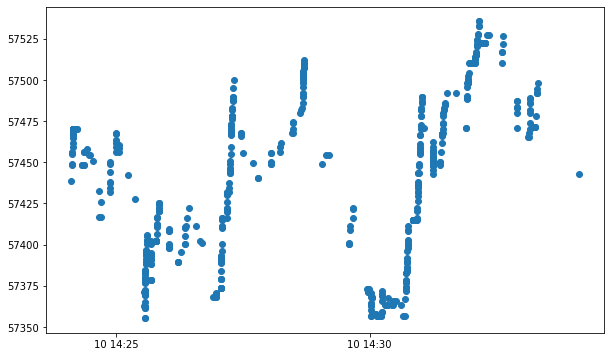

In [9]:
from collections import defaultdict


m = defaultdict(list)
for i, j in zip(*T.nonzero()):
    if i + 1 == T.shape[0]:  # skip cancel
        continue

    # at the timestamp and price of trade i, add the contribution to update j
    # there can be multiple trades at the same timestamp and price
    m[trades.timestamp.iat[i], trades.price.iat[i]].append(T[i, j])

pl.figure(figsize=(10, 6))
pl.scatter(*zip(*m.keys()))

In [111]:
def bookot(trades, updates):
    '''Match trades to negative order book updates.
    
    Parameters
    ----------
    trades:  pd.DataFrame with columns ('timestamp', 'amount', 'price')
    updates: pd.DataFrame with columns ('timestamp', 'amount', 'price')
    
    Returns
    -------
    ...
    '''
    
    nu = updates[updates.amount < 0]
    
    # compute trades and negative update amounts
    a  = trades.amount.values
    lm = - nu.amount.values

    # compute cost matrix
    pinf = 1e9  # pseudo infinity
    pdiff = np.where(np.subtract.outer(trades.price.values, updates.price.values) != 0, pinf, 0)
    tdiff = np.abs(np.subtract.outer(trades.timestamp.values, updates.timestamp.values).astype(float))
    C = tdiff + pdiff
    
    # add virtual trade
    a = np.append(a, (lm.sum() - a.sum()))
    C = np.vstack((C, np.zeros_like(n)))

    # compute optimal transport
    T = ot.emd(a, lm, C)
    return T

---

## Accounting for aggregations

There are two major dynamics our model does not account for. The first one is data aggregation: the possibility of an overlap between negative and positive liquidity changes ($\ell^+ \neq r$). The second is an implicit assumption we made about market orders: those are always fulfilled at a unique price. In reality market orders can be decomposed to match with several limit orders at different prices when a tick level's liquidity is exhausted.

Both our model and our transport problem must be adpated. The measures we use should be two-dimensional ($time$ and $price$). The optimal transport problem must be signed. The cost $C_{ij}$ must be adapted to reflect both proximity in time and proximity in price.

without aggregation:

set of trades  (t, tick, qty)
set of updates (t, tick, qty)

set of limits  (t, tick, qty) = updates with qty > 0
set of markets (t, qty) transported to updates - limits with T
set of cancels (t, tick, qty) = updates - limits - T(markets)